#Install dependencies

In [1]:
!pip install gym
!pip install gym_minigrid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 1.1 MB/s 
     |████████████████████████████████| 732 kB 11.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.25.1-py3-none-any.whl size=849051 sha256=2a3345967856e05a4269cc4a9b46f318ddda4c8631e968c09f921a2e651cdbf9
  Stored in directory: /root/.cache/pip/wheels/0e/2d/04/f964345f96b1348723057d60011be1e48885a027c9c5b92210
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


#Import packages

In [2]:
import gym
import gym_minigrid
from gym_minigrid.wrappers import *
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

#Create grid environment

In [3]:
env = ImgObsWrapper(gym.make("MiniGrid-Empty-8x8-v0"))
env.reset()

/usr/local/lib/python3.7/dist-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


array([[[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]], dtype=uint8)

#Convert RGB state array to  a tuple

In [4]:
def to_tuple(array):
    try:
        return tuple(to_tuple(item) for item in array)
    except TypeError:
        return array

#Define agent class

In [5]:
class QLearningAgent:
    def __init__(self, env, epsilon, learning_rate, discount_factor):
        self.epsilon = epsilon
        self.gamma = discount_factor
        self.lr = learning_rate
        self.q_table = {}
        self.n1 = 6473
        self.n2 = 7079

    def take_action(self, state, episode, step):
        # Generate random seed using two large primes, current episode and step
        seed = (episode * self.n1) + (step * self.n2)
        random.seed(seed)
        # Sample a random action
        random_action = random.randint(0,2)
        # Generate random number from 0 to 1, to be used for comparison with epsilon value
        random_num = random.uniform(0, 1)

        # Retrieve max Q-value, given the current state
        max_q_val = max(self.q_table[state, 0], self.q_table[state, 1], self.q_table[state, 2])

        # Find the action associated with the highest Q-value
        for key, value in self.q_table.items():
            if key[0] == state and value == max_q_val:
                max_action = key[1]

        # Epsilon greedy policy
        if random_num > self.epsilon:
            action = max_action  # Action associated with max Q-value
        else:
            action = random_action
        return action

    def update_q_table(self, state, action, reward, next_state):
        # Retrieve max Q-value associated with the next state
        max_q_val = max(self.q_table[next_state, 0], self.q_table[next_state, 1], self.q_table[next_state, 2])
        # Q-table update
        self.q_table[state, action] = self.q_table[state, action] + self.lr * (reward + self.gamma * max_q_val) - self.q_table[state, action]

In [6]:
# Agent hyperparameters 
discount_factor = 0.95
learning_rate = 0.1
max_epsilon = 1.0

agent = QLearningAgent(env=env, discount_factor=discount_factor, learning_rate=learning_rate, epsilon=max_epsilon)

#Training agent with no poisoning

In [7]:
# Training hyperparameters 
total_episodes = 5000
min_epsilon = 0.05
max_steps = 100
decay_rate = 0.0005

rewards_dict = {}
rewards_array = []

for episode in range(total_episodes):
  state = env.reset()
  # Decay epsilon exponentially
  agent.epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

  actions_taken = []
  total_rewards = 0

  for step in range(max_steps):
    state = to_tuple(state)
		
		# Check if state, action pair is in the Q-table if not create a key, value pair and set to 0
    for i in range(0, 3):
      state_action = state, i
      if state_action not in agent.q_table: 
        agent.q_table[state_action] = 0

    action = agent.take_action(state, episode, step)
    next_state, reward, done, info = env.step(action)
    actions_taken.append(action)
    total_rewards += reward
    
    next_state = to_tuple(next_state)
    
		# Check if next state, action pair is in the Q-table if not create a key, value pair and set to 0
    for i in range(0, 3):
      new_state_action = next_state, i
      if new_state_action not in agent.q_table:
        agent.q_table[new_state_action] = 0
      

    agent.update_q_table(state, action, reward, next_state)
    state = next_state

    if done:
      break

  rewards_dict['episode_number'] = episode
  rewards_dict['total_reward'] = total_rewards
  rewards_dict['steps'] = step
  rewards_dict["actions_taken"] = actions_taken

  rewards_array.append(dict(rewards_dict))

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:228: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  "Core environment is written in old step API which returns one bool instead of two. "


In [8]:
no_poisoning_df = pd.DataFrame(rewards_array)
no_poisoning_df

,episode_number,total_reward,steps,actions_taken
0,0,0.000000,99,"[1, 2, 2, 1, 0, 1, 1, 0, 2, 2, 0, 0, 1, 1, 0, ..."
1,1,0.000000,99,"[1, 2, 1, 2, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, ..."
2,2,0.000000,99,"[1, 1, 2, 1, 2, 0, 2, 2, 2, 0, 1, 2, 0, 0, 2, ..."
3,3,0.000000,99,"[0, 1, 0, 0, 2, 2, 0, 1, 0, 2, 2, 1, 2, 2, 0, ..."
4,4,0.000000,99,"[0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 1, 2, ..."
...,...,...,...,...
4995,4995,0.957812,11,"[2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2]"
4996,4996,0.950781,13,"[2, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2]"
4997,4997,0.950781,13,"[2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2]"
4998,4998,0.947266,14,"[2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2]"


In [9]:
no_poisoning_df['method'] = "no_poisoning"

In [10]:
no_poisoning_df["cumulative_reward"] = no_poisoning_df.total_reward.cumsum()

In [11]:
no_poisoning_df

,episode_number,total_reward,steps,actions_taken,method,cumulative_reward
0,0,0.000000,99,"[1, 2, 2, 1, 0, 1, 1, 0, 2, 2, 0, 0, 1, 1, 0, ...",no_poisoning,0.000000
1,1,0.000000,99,"[1, 2, 1, 2, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, ...",no_poisoning,0.000000
2,2,0.000000,99,"[1, 1, 2, 1, 2, 0, 2, 2, 2, 0, 1, 2, 0, 0, 2, ...",no_poisoning,0.000000
3,3,0.000000,99,"[0, 1, 0, 0, 2, 2, 0, 1, 0, 2, 2, 1, 2, 2, 0, ...",no_poisoning,0.000000
4,4,0.000000,99,"[0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 1, 2, ...",no_poisoning,0.000000
...,...,...,...,...,...,...
4995,4995,0.957812,11,"[2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2]",no_poisoning,4120.742578
4996,4996,0.950781,13,"[2, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2]",no_poisoning,4121.693359
4997,4997,0.950781,13,"[2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2]",no_poisoning,4122.644141
4998,4998,0.947266,14,"[2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2]",no_poisoning,4123.591406


In [12]:
no_poisoning_df.total_reward.sum()

4124.545703125

In [13]:
no_poisoning_df.total_reward.mean()

0.824909140625

#Training agent with no poisoning plots

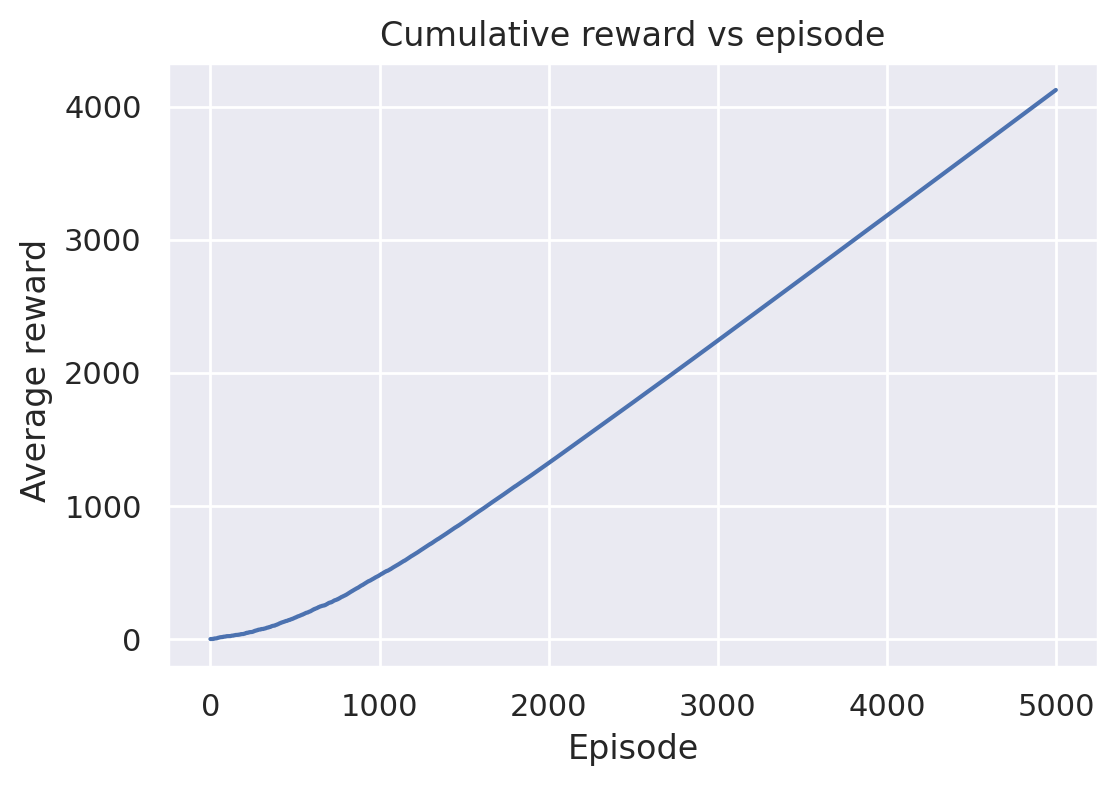

In [14]:
rcParams['figure.dpi'] = 200

sns.set()
ax = sns.lineplot(x=no_poisoning_df.episode_number, y=no_poisoning_df.cumulative_reward);

ax.set_xlabel("Episode")
ax.set_ylabel("Average reward ")
ax.set_title("Cumulative reward vs episode");
plt.savefig('Cumulative reward.pdf')

In [15]:
no_poisoning_df['average_reward'] = no_poisoning_df.total_reward.rolling(50).mean()

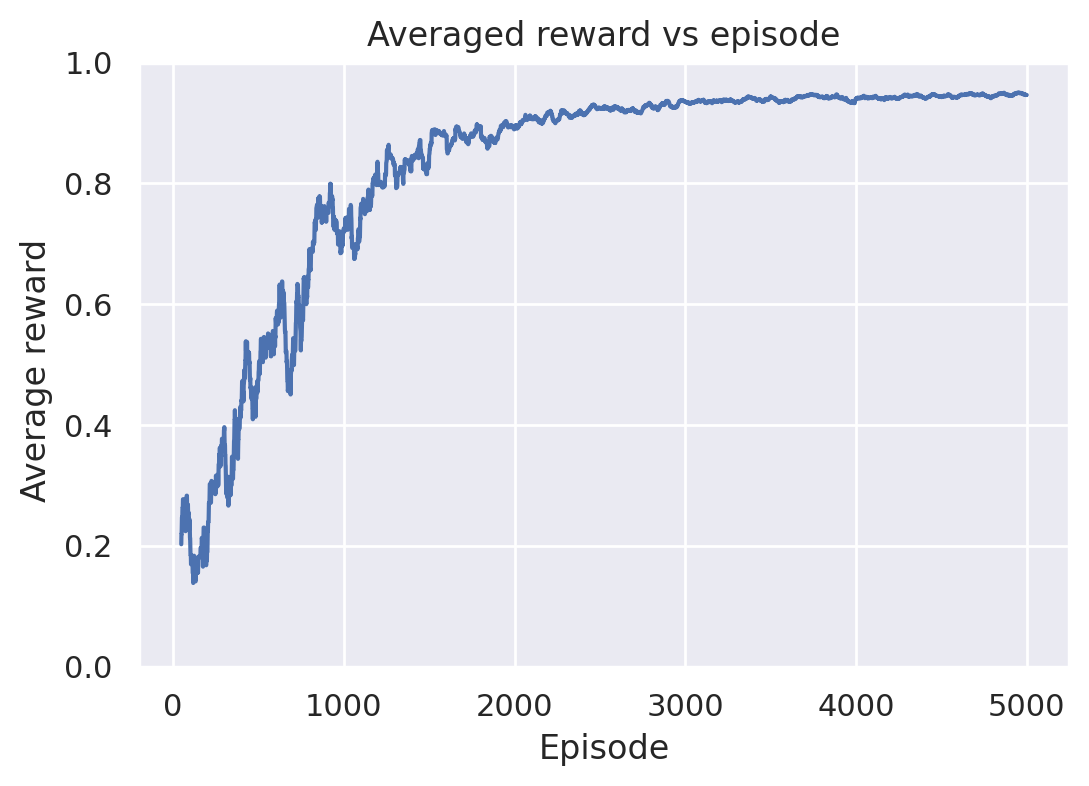

In [16]:
rcParams['figure.dpi'] = 200

sns.set()
ax = sns.lineplot(x=no_poisoning_df.episode_number, y=no_poisoning_df.average_reward);

ax.set_xlabel("Episode")
ax.set_ylabel("Average reward ")
ax.set_title("Averaged reward vs episode");
ax.set_ylim(0,1)
plt.savefig('average reward plot.pdf')

#Evaluating agent with no poisoning

In [17]:
max_steps = 100
eval_episodes = 100
env.reset()

eval_array = []
eval_dict = {}

for episode in range(eval_episodes):
  actions_taken = []
  state = env.reset()
  total_rewards = 0

  for step in range(max_steps):

    state = to_tuple(state)
    max_val = max(agent.q_table[state,0],agent.q_table[state,1],agent.q_table[state,2])
    for k,v in agent.q_table.items():
      if k[0] == state and v == max_val:
        max_action = k[1]
  
    next_state, reward, done, info = env.step(max_action)
    actions_taken.append(max_action)
    total_rewards += reward
    state = next_state

    if done:
      break

  eval_dict['total_reward'] = total_rewards
  eval_dict['episode_number'] = episode  
  eval_dict['steps'] = step
  eval_dict["actions_taken"] = actions_taken
  eval_array.append(dict(eval_dict))

In [18]:
eval_df = pd.DataFrame(eval_array)
eval_df

,total_reward,episode_number,steps,actions_taken
0,0.957812,0,11,"[2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2]"
1,0.957812,1,11,"[2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2]"
2,0.957812,2,11,"[2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2]"
3,0.957812,3,11,"[2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2]"
4,0.957812,4,11,"[2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2]"
...,...,...,...,...
95,0.957812,95,11,"[2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2]"
96,0.957812,96,11,"[2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2]"
97,0.957812,97,11,"[2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2]"
98,0.957812,98,11,"[2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2]"


#Adversary class

In [19]:
class AdversaryAgent:
  def __init__(self, episode, step, total_eps):
    self.episode = episode
    self.step = step
    self.total_eps = total_eps
    self.n1 = 6473
    self.n2 = 7079
    self.budget = total_eps * 35

 
  def get_noise(self, mu, sigma):
    seed = (self.episode*self.n1) + (self.step*self.n2)
    np.random.seed(seed)
    noise = np.random.normal(mu, sigma)
    if self.budget > 0:
      self.budget -= abs(noise)
      return noise
    else:
      return 0

In [20]:
episode = None
step = None
total_eps = 5000

adversary = AdversaryAgent(episode, step, total_eps)

#Training agent with simple poisoning

In [21]:
# Agent hyperparameters 
discount_factor = 0.95
learning_rate = 0.1
max_epsilon = 1.0

agent = QLearningAgent(env=env, discount_factor=discount_factor, learning_rate=learning_rate, epsilon=max_epsilon)

In [22]:
# Training hyperparameters 
total_episodes = 5000
min_epsilon = 0.05
max_steps = 100
decay_rate = 0.0005

rewards_dict = {}
rewards_array = []

for episode in range(total_episodes):
  state = env.reset()
  # Decay epsilon exponentially
  agent.epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

  actions_taken = []
  noise_added = 0
  total_rewards = 0
  reward_with_no_noise = 0

  for step in range(max_steps):
    state = to_tuple(state)

    # Provide episode and step data to adversary and sample noise value
    adversary.episode = episode
    adversary.step = step
    noise = adversary.get_noise(0,0.75)

    for i in range(0, 3):
      state_action = state, i
      if state_action not in agent.q_table: 
        agent.q_table[state_action] = 0

    action = agent.take_action(state, episode, step)
    next_state, reward, done, info = env.step(action)

    actions_taken.append(action)
    reward_with_no_noise += reward 

    if done == True or step == 99:
      total_rewards += (reward + noise)
      noise_added += noise
    


    
      next_state = to_tuple(next_state)
      for i in range(0, 3):
        new_state_action = next_state, i
        if new_state_action not in agent.q_table:
          agent.q_table[new_state_action] = 0
      

      agent.update_q_table(state, action, total_rewards, next_state)
      break
    

    else:
      total_rewards += reward
      next_state = to_tuple(next_state)
      for i in range(0, 3):
        new_state_action = next_state, i
        if new_state_action not in agent.q_table:
          agent.q_table[new_state_action] = 0
      
      agent.update_q_table(state, action, total_rewards, next_state)
      state = next_state 


  # New dict containing total reward and episode  is added to a list at the end of each episode

  rewards_dict['episode_number'] = episode
  rewards_dict['total_reward'] = total_rewards
  rewards_dict["reward_with_no_noise"] = reward_with_no_noise
  rewards_dict["noise_added"] = noise_added
  rewards_dict['steps'] = step
  rewards_dict["actions_taken"] = actions_taken

  rewards_array.append(dict(rewards_dict))

In [23]:
simple_poisoning_df = pd.DataFrame(rewards_array)
simple_poisoning_df

,episode_number,total_reward,reward_with_no_noise,noise_added,steps,actions_taken
0,0,0.515649,0.000000,0.515649,99,"[1, 2, 2, 1, 0, 1, 1, 0, 2, 2, 0, 0, 1, 1, 0, ..."
1,1,-0.864385,0.000000,-0.864385,99,"[1, 2, 1, 2, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, ..."
2,2,0.058972,0.000000,0.058972,99,"[1, 1, 2, 1, 2, 0, 2, 2, 2, 0, 1, 2, 0, 0, 2, ..."
3,3,-0.235140,0.000000,-0.235140,99,"[0, 1, 0, 0, 2, 2, 0, 1, 0, 2, 2, 1, 2, 2, 0, ..."
4,4,-0.447505,0.000000,-0.447505,99,"[0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 1, 2, ..."
...,...,...,...,...,...,...
4995,4995,0.957812,0.957812,0.000000,11,"[2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2]"
4996,4996,0.950781,0.950781,0.000000,13,"[2, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2]"
4997,4997,0.950781,0.950781,0.000000,13,"[2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2]"
4998,4998,0.933203,0.933203,0.000000,18,"[2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 0, 2, ..."


In [24]:
simple_poisoning_df['method'] = "simple_poisoning"

In [25]:
simple_poisoning_df['cumulative_reward'] = simple_poisoning_df.reward_with_no_noise.cumsum()

In [26]:
simple_poisoning_df

,episode_number,total_reward,reward_with_no_noise,noise_added,steps,actions_taken,method,cumulative_reward
0,0,0.515649,0.000000,0.515649,99,"[1, 2, 2, 1, 0, 1, 1, 0, 2, 2, 0, 0, 1, 1, 0, ...",simple_poisoning,0.000000
1,1,-0.864385,0.000000,-0.864385,99,"[1, 2, 1, 2, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, ...",simple_poisoning,0.000000
2,2,0.058972,0.000000,0.058972,99,"[1, 1, 2, 1, 2, 0, 2, 2, 2, 0, 1, 2, 0, 0, 2, ...",simple_poisoning,0.000000
3,3,-0.235140,0.000000,-0.235140,99,"[0, 1, 0, 0, 2, 2, 0, 1, 0, 2, 2, 1, 2, 2, 0, ...",simple_poisoning,0.000000
4,4,-0.447505,0.000000,-0.447505,99,"[0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 1, 2, ...",simple_poisoning,0.000000
...,...,...,...,...,...,...,...,...
4995,4995,0.957812,0.957812,0.000000,11,"[2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2]",simple_poisoning,2895.448828
4996,4996,0.950781,0.950781,0.000000,13,"[2, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2]",simple_poisoning,2896.399609
4997,4997,0.950781,0.950781,0.000000,13,"[2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2]",simple_poisoning,2897.350391
4998,4998,0.933203,0.933203,0.000000,18,"[2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 0, 2, ...",simple_poisoning,2898.283594


In [27]:
simple_poisoning_df.reward_with_no_noise.mean()

0.5798454687500001

In [28]:
simple_poisoning_df.reward_with_no_noise.sum()

2899.2273437500003

#Evaluating agent with simple poisoning

In [29]:
max_steps = 100
eval_episodes = 100
env.reset()

eval_array = []
eval_dict = {}

for episode in range(eval_episodes):
  actions_taken = []
  state = env.reset()
  total_rewards = 0

  for step in range(max_steps):

    state = to_tuple(state)
    max_val = max(agent.q_table[state,0],agent.q_table[state,1],agent.q_table[state,2])
    for k,v in agent.q_table.items():
      if k[0] == state and v == max_val:
        max_action = k[1]
  
    next_state, reward, done, info = env.step(max_action)
    actions_taken.append(max_action)
    total_rewards += reward
    state = next_state

    if done:
      break

  eval_dict['total_reward'] = total_rewards
  eval_dict['episode_number'] = episode  
  eval_dict['steps'] = step
  eval_dict["actions_taken"] = actions_taken
  eval_array.append(dict(eval_dict))

In [30]:
eval_df = pd.DataFrame(eval_array)
eval_df

,total_reward,episode_number,steps,actions_taken
0,0.94375,0,15,"[2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2]"
1,0.94375,1,15,"[2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2]"
2,0.94375,2,15,"[2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2]"
3,0.94375,3,15,"[2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2]"
4,0.94375,4,15,"[2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2]"
...,...,...,...,...
95,0.94375,95,15,"[2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2]"
96,0.94375,96,15,"[2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2]"
97,0.94375,97,15,"[2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2]"
98,0.94375,98,15,"[2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2]"


#Training agent with convergence poisoning 

In [31]:
discount_factor = 0.95
learning_rate = 0.1
max_epsilon = 1.0

agent = QLearningAgent(env=env, discount_factor=discount_factor, learning_rate=learning_rate, epsilon=max_epsilon)

In [32]:
episode = None
step = None
total_eps = 5000

adversary = AdversaryAgent(episode, step, total_eps)

In [33]:
# Training hyperparameters 
total_episodes = 5000
min_epsilon = 0.05
max_steps = 100
decay_rate = 0.0005

rewards_dict = {}
rewards_array = []

for episode in range(total_episodes):
  state = env.reset()
  # Decay epsilon exponentially
  agent.epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

  actions_taken = []
  noise_added = 0
  total_rewards = 0
  reward_with_no_noise = 0

  for step in range(max_steps):
    state = to_tuple(state)

    # Provide episode and step data to adversary and sample noise value
    adversary.episode = episode
    adversary.step = step

    for i in range(0, 3):
      state_action = state, i
      if state_action not in agent.q_table: 
        agent.q_table[state_action] = 0

    action = agent.take_action(state, episode, step)
    next_state, reward, done, info = env.step(action)
    
    actions_taken.append(action)
    reward_with_no_noise += reward

    if reward > 0.75 and episode > 800:
      
      noise = adversary.get_noise(0,0.75)
      reward = reward + noise
      total_rewards += reward 
      
      noise_added += noise

      next_state = to_tuple(next_state)
      for i in range(0, 3):
        new_state_action = next_state, i
        if new_state_action not in agent.q_table:
          agent.q_table[new_state_action] = 0
        
      agent.update_q_table(state, action, reward, next_state)
      break

    elif done == True: 
        total_rewards += reward 
        # reward_with_no_noise += reward 
        # agent.update_q_table(state, action, reward, next_state)
        break 

    else:
      next_state = to_tuple(next_state)
      for i in range(0, 3):
        new_state_action = next_state, i
        if new_state_action not in agent.q_table:
          agent.q_table[new_state_action] = 0

      agent.update_q_table(state, action, reward, next_state)
      state = next_state 


  
  # New dict containing total reward and episode  is added to a list at the end of each episode

  rewards_dict['episode_number'] = episode
  rewards_dict['total_reward'] = total_rewards
  rewards_dict["reward_with_no_noise"] = reward_with_no_noise
  rewards_dict["noise_added"] = noise_added
  rewards_dict['steps'] = step
  rewards_dict["actions_taken"] = actions_taken

  rewards_array.append(dict(rewards_dict))

In [34]:
convergence_poisoning_df = pd.DataFrame(rewards_array)
convergence_poisoning_df

,episode_number,total_reward,reward_with_no_noise,noise_added,steps,actions_taken
0,0,0.0,0.0,0.0,99,"[1, 2, 2, 1, 0, 1, 1, 0, 2, 2, 0, 0, 1, 1, 0, ..."
1,1,0.0,0.0,0.0,99,"[1, 2, 1, 2, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, ..."
2,2,0.0,0.0,0.0,99,"[1, 1, 2, 1, 2, 0, 2, 2, 2, 0, 1, 2, 0, 0, 2, ..."
3,3,0.0,0.0,0.0,99,"[0, 1, 0, 0, 2, 2, 0, 1, 0, 2, 2, 1, 2, 2, 0, ..."
4,4,0.0,0.0,0.0,99,"[0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 1, 2, ..."
...,...,...,...,...,...,...
4995,4995,0.0,0.0,0.0,99,"[2, 1, 2, 0, 2, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, ..."
4996,4996,0.0,0.0,0.0,99,"[2, 2, 0, 1, 0, 1, 0, 1, 2, 2, 1, 2, 2, 2, 1, ..."
4997,4997,0.0,0.0,0.0,99,"[2, 1, 0, 1, 2, 0, 2, 2, 1, 2, 0, 2, 1, 0, 1, ..."
4998,4998,0.0,0.0,0.0,99,"[2, 1, 2, 0, 2, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, ..."


In [35]:
convergence_poisoning_df.reward_with_no_noise.mean()

0.44365007812500007

In [36]:
convergence_poisoning_df.reward_with_no_noise.sum()

2218.2503906250004

In [37]:
convergence_poisoning_df["method"] = "convergence_poisoning"

In [38]:
convergence_poisoning_df["cumulative_reward"] = convergence_poisoning_df.reward_with_no_noise.cumsum()

#Evaluating agent with convergence poisoning

In [39]:
max_steps = 100
eval_episodes = 100
env.reset()

eval_array = []
eval_dict = {}


for episode in range(eval_episodes):
  actions_taken = []
  state = env.reset()
  total_rewards = 0

  for step in range(max_steps):

    state = to_tuple(state)
    max_val = max(agent.q_table[state,0],agent.q_table[state,1],agent.q_table[state,2])
    for k,v in agent.q_table.items():
      if k[0] == state and v == max_val:
        max_action = k[1]
  
    next_state, reward, done, info = env.step(max_action)
    actions_taken.append(max_action)
    total_rewards += reward
    state = next_state

    if done:
      break

  eval_dict['total_reward'] = total_rewards
  eval_dict['episode_number'] = episode  
  eval_dict['steps'] = step
  eval_dict["actions_taken"] = actions_taken
  eval_array.append(dict(eval_dict))

In [40]:
eval_df = pd.DataFrame(eval_array)
eval_df

,total_reward,episode_number,steps,actions_taken
0,0,0,99,"[2, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, ..."
1,0,1,99,"[2, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, ..."
2,0,2,99,"[2, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, ..."
3,0,3,99,"[2, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, ..."
4,0,4,99,"[2, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, ..."
...,...,...,...,...
95,0,95,99,"[2, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, ..."
96,0,96,99,"[2, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, ..."
97,0,97,99,"[2, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, ..."
98,0,98,99,"[2, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, ..."


#Final results

In [41]:
frames = [convergence_poisoning_df, simple_poisoning_df, no_poisoning_df, ]
combined_results = pd.concat(frames, ignore_index=True)

In [ ]:
combined_results

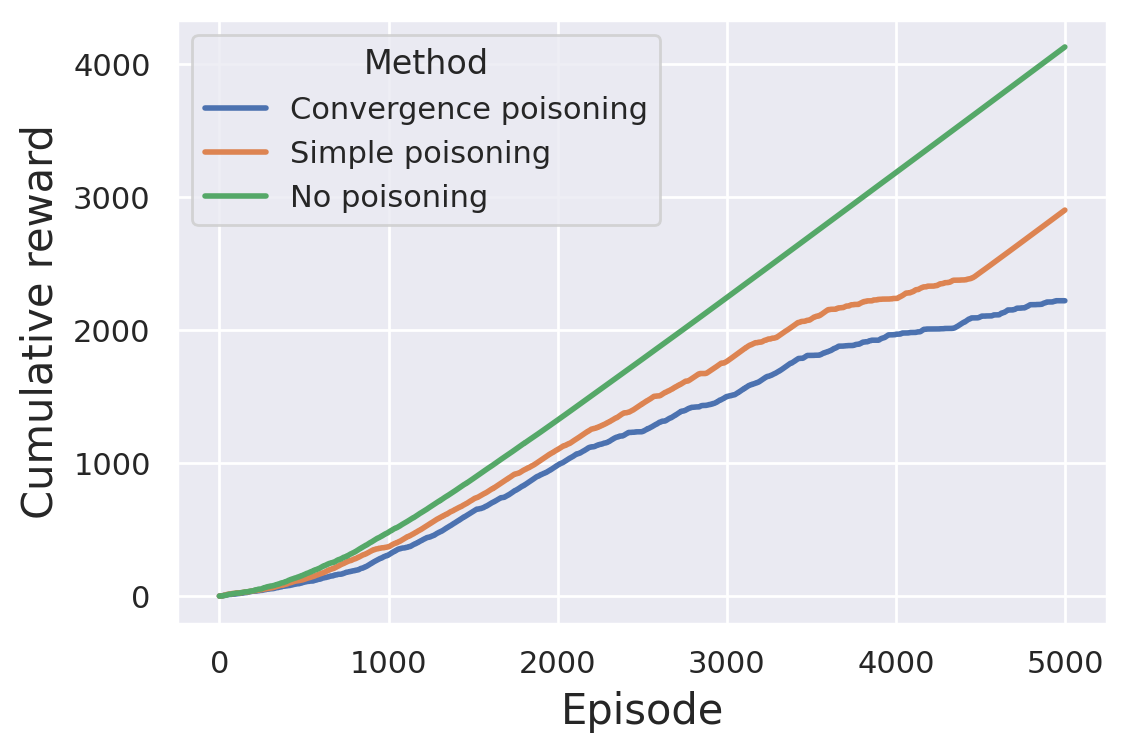

In [43]:
rcParams['figure.dpi'] = 200

sns.set()
ax = sns.lineplot(x=combined_results.episode_number, y=combined_results.cumulative_reward, hue=combined_results.method, lw=2)
ax.set_xlabel("Episode", fontsize=15)
ax.set_ylabel("Cumulative reward", fontsize=15)
ax.set_title("");
plt.legend(labels=["Convergence poisoning","Simple poisoning", "No poisoning"], title = "Method")